# How to use perplexity to select an optimal VBEM prior for Salmon

Spencer Skylar Chan

## Introduction

RNA transcript abundance estimation is the standard computational method to count the number of RNA fragments in an RNA sample belonging to transcripts (for example, genes of interest). Counting RNAs is useful for downstream analysis such as differential expression, which computes the up- and down-regulation of the genes which produced the RNAs. Knowing which genes are more or less expressed can be useful for studying diseases such as cancer

The RNA transcript abundance algorithm is this:

**Input:** RNA reads and a transcriptome.

**Output:** Expected value of fragments mappings to transcripts. Equivalenty, the expected number of RNAs generated per transcript in the transcriptome.

One RNA transcript quantification algorithm is [Salmon](https://www.nature.com/articles/nmeth.4197) which is developed by Professor Rob Patro (my PI) at UMD. Salmon can perform transcript quantification using Variational Bayes Expectation Maximization (VBEM). When using VBEM, Salmon can accept a hyperparameter `--vbprior`, which is the per-nucleotide VBEM prior. According to the Salmon [documentatation](https://salmon.readthedocs.io/en/latest/salmon.html#useem):

> The default prior used in the VB optimization is a per-nucleotide prior of 1e-5 reads per-nucleotide. This means that a transcript of length 100000 will have a prior count of 1 fragment, while a transcript of length 50000 will have a prior count of 0.5 fragments, etc.

This prior is essentially the background expression expected in this sample. A smaller prior size will result in a sparser estimate. A larger prior size will result in more non-zero estimates. It is important to select a VBEM prior that makes sense for the reads you want to quantify.

Thus, model selection through evaluating RNA abundance estimates is a learning problem. We could evaluate estimates directly with a known transcript expression distribution, aka the ground truth. But we usually don't have this ground truth. If we have simulated data, we can compare the transcript abundance quantification estimate (quant) with the ground truth from which we simulated our data from using a metric like Spearman correlation. But simulated reads are not as interesting as real reads extracted from cells. With real reads, we don't know the ground truth, in fact this is usually what we are trying to find out! We could use quantitative PCR to perform transcript quantification using fluorescent nucleotides. But qPCR is not the most reliable way to count RNAs, so most people send reads for sequencing instead of doing qPCR with them.

Since we can't rely on the the ground truth for evaluating transcript abundance estimates, let's evalute estimates without the ground truth! In other words, let's make hyperparameter selection an unsupervised learning problem. We described in a [paper](https://drops.dagstuhl.de/opus/volltexte/2021/14357/) how to measure the accuracy of an abundance estimate using a quantify-then-validate approach. The evaluation metric we use is an adaptation of perplexity from natural language processing to transcriptomics. In this context, perplexity is the inverse geometric mean _per-read_ likelihood of a held-out test set. To compute perplexity, we split our reads into a test set and training set. We *quantify* an abundance estimate on the training set, holding out the test set. Then we *validate* our abundance estimate by computing perplexity on the estimate and the held-out reads. Figure 2 from our paper, shown below, is a visual representation of what I described above.

<img src="../figures/perplexity-figure2.png" width=600 height=600 />

The lower the perplexity, the better the abundance estimate describes the held-out reads. Therefore, perplexity is a proxy for the goodness of an abundance estimate. You can think of perplexity as the error metric for abundance estimates. We show in the paper that the abundance estimates with the VBEM corresponding to the lowest perplexity have the highest Spearman correlation with the ground truth distributions of simulated data. The moral of the story is that hyperparameter selection for transcript quantification algorithms is now possible. In the case of Salmon and VBEM prior, the problem becomes:

**Input:** RNA reads and a transcriptome.

**Output:** the best VBEM prior, which is the one that generates the abundance estimate with the smallest perplexity

In this tutorial I will demonstrate hyperparameter selection of the VBEM prior using perplexity using k-fold cross validation, in the absence of ground truth.

## Setup

Open a shell and clone my perplexity repository. It's a fork of the COMBINE lab's repositorys ([perplexity](https://github.com/COMBINE-lab/perplexity) and [perplexity-paper](https://github.com/COMBINE-lab/perplexity-paper)). You'll have to checkout the `tutorial` branch.

```sh
git clone https://github.com/schance995/perplexity.git
cd perplexity
git checkout tutorial
```

The source code for the `perplexity` program is included. It's written in Rust, which is a compiled language. If you don't have Rust installed already, download and run Rustup, which manages the Rust toolchain.

```sh
curl --proto '=https' --tlsv1.2 -sSf https://sh.rustup.rs -o rustup-installer.sh
# check that the script looks ok
less ./rustup-installer.sh
# run the installer
sh ./rustup-installer.sh
# download the stable Rust toolchain
rustup default stable
```

Once you have installed Rust, compile the perplexity binary.

```sh
cargo build --release
```

Next we'll install some Conda packages. One drawback of Conda is that it resolves even simple dependencies very slowly. A solution is [Mamba](https://github.com/mamba-org/mamba), which resolves dependencies faster. You can install Mamba if you already have Conda, otherwise check the [installation guide]((https://github.com/mamba-org/mamba#installation)).

```sh
conda install mamba -n base -c conda-forge
```

Mamba has a [limitation](https://github.com/mamba-org/mamba/issues/633#issuecomment-812272143) where it cannot create new environments from an environment file. As a workaround, create a new environment, then update it with `env.yml`:

```sh
conda env create -n tutorial
mamba env update -n tutorial --file env.yml
```

Activate the environment to make the programs available in your path.

```sh
conda activate tutorial
```

Now we are ready to configure the pipeline.

## Configuration

We use [Snakemake](https://snakemake.github.io), which is "a framework for reproducible data analysis". Think GNU Make, but for data science. It helps us run parallel, reproducible pipelines. Snakemake will generate all output files from input files and will run the intermediate steps in the correct order.

Before running the pipeline, edit `snakefiles/config.yml`,which is the configuration file to declare the inputs to the analysis.

```yaml
# results will go in {out-dir}/{exp-name}
out-dir: output
exp-name: tutorial

# expects paired end reads with format:
#    {reads-dir}/{sample_name}_1.fasta
#    {reads-dir}/{sample_name}_2.fasta
read_file_fmt: fasta
# replace with your reads directory
reads-dir: /fs/cbcb-lab/rob/students/jason/shared/SRR1265495/
# replace with your sample names to quantify (can be more than 1)
sample-names:
  - sample_01
  # - sample_02

# Path to reference transcriptome for salmon (replace with your transcriptome)
txome-path: /fs/cbcb-lab/rob/students/jason/shared/annotations/hg19_clean.fa

# where to find folds, recommended to put this in {current working directory}/output/tutorial/folds
# for example my working directory is /fs/cbcb-lab/rob/students/skylar/perplexity
folds-dir: /fs/cbcb-lab/rob/students/skylar/perplexity/output/tutorial/folds

# Path to perplexity binary, and kfolds.sh script
perplexity-bin: target/release/perplexity
kfold-script: scripts/kfolds.sh

# Number of folds
k: 5

# VBEM priors to test with
# The default value is 1e-5
prior-weights:
  - 1e-6
  - 1e-5
  - 1e-4
  - 1e-3
  - 1e-2
  - 1e-1
  - 1e0
  - 1e1
  - 1e2
  - 2
  - 3
  - 4
  - 5
  - 6
  - 7 
  - 8
  - 9
```

## Run the pipeline

### Generate k folds

The first step of the pipeline is to create k folds for cross-validation. Specify the snakefile to run with --snakefile and the config file you wrote earlier with --configfile. It is a good idea to use the `-n` flag to simulate the run and conserve CPU cycles and disk writes.

```sh
# check the files that this snakefile will produce
snakemake --snakefile snakefiles/kfold.snk --configfile <config file> -n
```
The proposed output should list the rules that will be run and the files that will be generated from this Snakefile. This Snakefile will prepare train and test sets suitable for k-fold cross-validation. It simply calls a helper script (`kfold.sh`) to achieve this [<sup>1</sup>](#fn1). It will multiply the disk space used by your reads by $k$, which should not be a problem for a cluster but might be a problem for a small hard drive.

When you are ready to run the snakefile, remove `-n` and add `-j <n cores>` to the command, where `n cores` is the maximum number of jobs you want Snakemake to run at any given time. If you specify `-j` without a number, the number of available cores will be used. This is fine if you have sufficient memory and CPU available [<sup>2</sup>](#fn2), but if you run many large samples, the Linux OOM daemon might terminate Salmon and other programs using high memory. For example, to run the pipeline with at most 8 jobs at a time:

```sh
# run the pipeline for real
snakemake --snakefile snakefiles/kfold.snk --configfile <config file> -j <n cores>
```

This will take a few minutes per sample, depending on the size of your data.

### Tanscript quantification, cross-validation and perplexity calculation

After the kfolds snakefile is finished, let's do the same yoga for the perplexity snakefile.

```sh
# check the files that this snakefile will produce
snakemake --snakefile snakefiles/perplexity.snk --configfile <config file> -n
```

There are many steps to this snakefile. First, the transcriptome will be indexed. Then Salmon will compute transcript abundance estimates for each fold and VBEM prior. Finally, perplexity will be computed using the `perplexity` binary.

```sh
# run the pipeline for real
snakemake --snakefile snakefiles/perplexity.snk --configfile <config file> -j <n jobs>
```

This will take longer than creating the k-folds, so you might want to grab a cup of coffee (or tea).

### Inspect the perplexity results

Let's take a look at one of the perplexity output files. For the purposes of this tutorial I've included the outputs in `example/output` of the repository. Take a look at `example-output/tutorial/perplexity/sample_01/vbprior=1e-5/beta=1e-8/1/perplexity.yml`:

```yaml
---
smoothed_perplexity: 1500.9738357618098
n_ecs: 188424
n_reads: 3035878
n_possible_ecs: 185426
n_possible_reads: 3032506
n_impossible_ecs: 2998
n_impossible_reads: 3372
n_discarded_ecs: 665
n_discarded_reads: 733
class_ec_freq:
...
```

This abundance estimate was generated with a VBEM prior of 1e-5, and the perplexity is about 1501. There's extra information about the kinds of reads and equivalence classes [<sup>3</sup>](#fn3) encountered in this sample.

You might also wonder why it says smoothed perplexity. The reason is because of impossible reads, which are reads in the test set could have 0 probability of being generated from the training set. In fact, in Figure 1 of our paper, we show that impossible reads occur rather frequently. The biggest problem with impossible reads is that perplexity will call abundance estimates with any number of impossible reads equallly bad. The solution is to use smoothing to smooth the probability distribution of the reads, which is to apply a small prior probability for each read. We discuss this in more detail in sections 3.1 and 3.2 of the paper. Although the paper used Laplacian smoothing, the perplexity binary has since been updated to use the [Linear Good Turing estimator](https://pageperso.lif.univ-mrs.fr/~alexis.nasr/Ens/M17b/smoothgoodturing.pdf) instead.

## Visualize the perplexities and VBEM priors for each fold

To perform hyperparameter selection with perplexity, we'll need to visualize all of the perplexities for each sample and VBEM prior.

Let's use some Python data science to achieve this. First, import the following packages into a Python session.

In [1]:
# import packages
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import yaml

%matplotlib inline

Next, load the config file we used for the Snakemake pipelines into our session. We'll extract the information we need to find all of the perplexity outputs.

In [2]:
# if you ran the pipeline for real earlier, just use ../output/{so on}
perp_fp_fmt = '../example/output/tutorial/perplexity/{sample}/vbprior={vb_prior}/beta=1e-8/{fold}/perplexity.yml'

exp_config = '../snakefiles/config.yml'
with open(exp_config, 'r') as f:
    cfg = yaml.safe_load(f)
    SAMPLES = cfg['sample-names']
    K = cfg['k']
    VB_PRIORS = [str(w) for w in cfg['prior-weights']]

Now define and run a function to plot the log 10 VBEM prior against the perplexity for each fold.

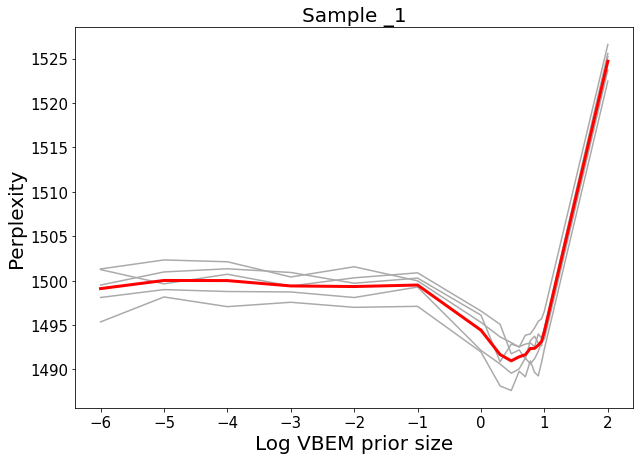

The smallest perplexity is 1487
The VBEM at the smallest perplexity is 3.0


In [3]:
def perplexity_plot(sample, vb_priors, folds):
    df = pd.DataFrame()
    for vb_prior in vb_priors:
        for fold in range(1, folds + 1):
            with open(perp_fp_fmt.format(sample=sample, vb_prior=vb_prior, fold=fold), 'r') as f:
                perp_result = yaml.safe_load(f)
            _vb_prior = float(vb_prior)
            df = df.append(dict(perplexity=perp_result['smoothed_perplexity'],
                                vb_prior=_vb_prior, log_vb_prior = np.log10(_vb_prior),
                                fold=fold), 
                           ignore_index=True)

    # find the minimum value in the df and convert to base 10 (not in logs)
    fig, ax = plt.subplots(1, 1, figsize=(10, 7))
    ax.set_title('Sample {}{}'.format(sample[-3], sample[-1]), fontsize=20)
    sns.lineplot(x="log_vb_prior", y="perplexity", data=df, ax=ax, units="fold", estimator=None, color='#AAAAAA')
    sns.lineplot(x="log_vb_prior", y="perplexity", data=df, ax=ax, err_style=None, lw=3, color="red")

    ax.set_ylabel('Perplexity', fontsize=20)
    ax.set_xlabel('Log VBEM prior size', fontsize=20)
    ax.tick_params(axis='both', which='major', labelsize=15)

    plt.show()
    small = df.nsmallest(1, 'perplexity')
    print('The smallest perplexity is ' + str(int(small['perplexity'].values[0])))
    print('The VBEM at the smallest perplexity is ' + str(10**small['log_vb_prior'].values[0]))
    return ax

for sample in SAMPLES:
    perplexity_plot(sample, VB_PRIORS, 5)

The x-axis is the log 10 VBEM prior size, and the y-axis is the perplexity. Each gray line is the perplexity and associated VBEM prior for each fold. The red line is the average perplexity per VBEM and fold.

## Select the VBEM with the smallest perplexity

Since perplexity is our measure of error, we should select the VBEM that produces the smallest perplexity. The minimum perplexity is present in the dip between 0 and 1, which means that in this example, the smallest prior is 3. Therefore we should run Salmon with --vbprior=3 for this sample; the resulting quant should be the best to use for downstream analysis such as differential expression. Note that the optimal prior as suggested by the smallest perplexity will depend on your sample.

Perplexity can also be used to investigate other RNA transcript quantification questions.

## How does read depth impact the optimal VBEM prior?

Increasing the sample size is a surefire way to improve the accuracy and confidence of an estimate. In RNA sequencing, the number of reads is known as the read depth. Most experiments require 5-200 million reads per sample, according to [Illumina](https://support.illumina.com/bulletins/2017/04/considerations-for-rna-seq-read-length-and-coverage-.html). Increasing the read depth also increases the likelihood of capturing rare transcripts. With this in mind, I hypothesize that the VBEM prior will decrease as the read depth increases. This is because when there are more reads, we are more certain to find rare transcripts, so we can assign a lower prior to them.

To test this hypothesis, we'll use holdout evaluation on different samples of 10 to 40 million reads drawn from the same distribution (or organism), with a test set of 20 million reads. To keep it fair, we'll keep the test set the same for each sample. There's a caveat that different reads will be called impossible for each sample, but it should not get in the way of seeing a general trend.

If you just want to see the results, you can skip to the plots made with the perplexity outputs in `example/output/readdepth`. Otherwise keep reading.

### Simulate reads

Reads will be simulated with [Polyester](https://www.bioconductor.org/packages/release/bioc/html/polyester.html) with a distribution based on an abundance estimate. Modify `config-simul.yml` to declare your inputs

```yaml
# results will go in output/{exp-name}
exp_name: simul_reads
# reads to base the simulation off of
reads_dir: /fs/cbcb-lab/rob/students/jason/shared/COPD-raw-data/output
# transcript to generation abundance estimate
tx_path: /fs/cbcb-lab/rob/students/jason/shared/annotations/hg19_clean.fa
# name of samples to use
sample_names:
  - SRR1265600
```

Polyester only simulates a fixed number of reads dependent on the size of the quant matrix input. In this instance each simulated sample is 14.7 million reads. This will take about half an hour.

```sh
snakemake --snakefile snakefiles/simul_data.snk --configfile snakefiles/config-simul.yml -j <n cores>
```

To combine the reads into test and train sets, run the `shuffle-reads.sh` script in the directory that the reads were generated in. This will take a few hours to complete. Make sure you have enough disk space too because this will create several uncompressed copies of fasta files.

```sh
cd ../output/simul_reads/simulated_reads/SRR1265600
sh {repo directory}/scripts/shuffle-reads.sh
```

### Quantify and validate

Finally edit `snakefiles/config-readdepth.yml`, and specify the samples that we simulated.

```yaml
read_file_fmt: fasta
reads-dir: /fs/cbcb-lab/rob/students/skylar/perplexity/output/simul_reads/simulated_reads/SRR1265600
sample-names:
  - 10_million_reads
  - 20_million_reads
  - 30_million_reads
  - 40_million_reads
  - 50_million_reads
  - 60_million_reads
  - 70_million_reads
  - 80_million_reads
```

Then run the Snakefile for read depth, which will do quantification and holdout validation. Make sure to use a small `-j`. This can take several hours, maybe even a day or two, so feel free to work on something else and come back.

```sh
snakemake --snakefile snakefiles/readdepth.snk --configfile snakefiles/config-readdepth.yml -j <n cores>
```

### Plot perplexity and log VBEM for samples of varying read depth

Welcome back. Let's plot the perplexities against log VBEM again. Since we did holdout validation and not k-folds cross-validation, there will only be one line to plot per sample.

In [4]:
# if you ran the pipeline for real earlier, just use ../output/{so on}
perp_fp_fmt = '../example/output/readdepth/perplexity/{sample}/vbprior={vb_prior}/beta=1e-8/perplexity.yml'

exp_config = '../snakefiles/config-readdepth.yml'
with open(exp_config, 'r') as f:
    cfg = yaml.safe_load(f)
    # only select first 4 for now
    SAMPLES = cfg['sample-names'][:4]
    VB_PRIORS = [str(w) for w in cfg['prior-weights']]

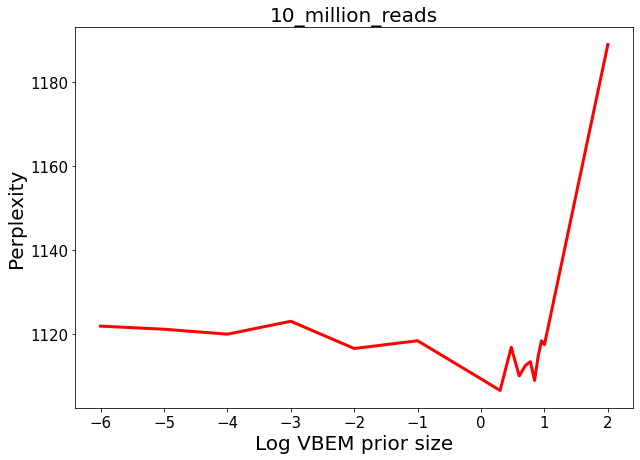

The smallest perplexity is 1106
The VBEM at the smallest perplexity is 2.0


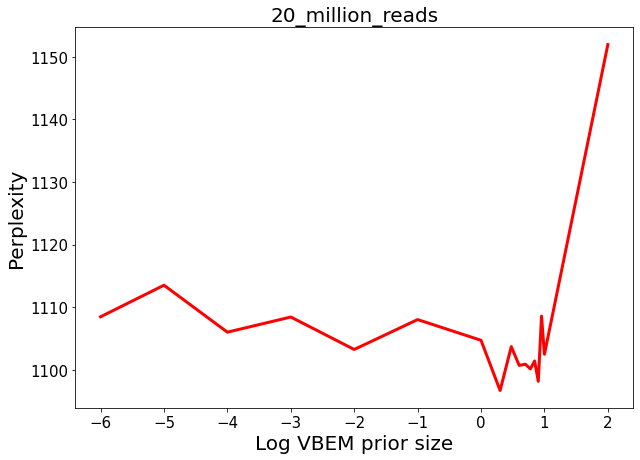

The smallest perplexity is 1096
The VBEM at the smallest perplexity is 2.0


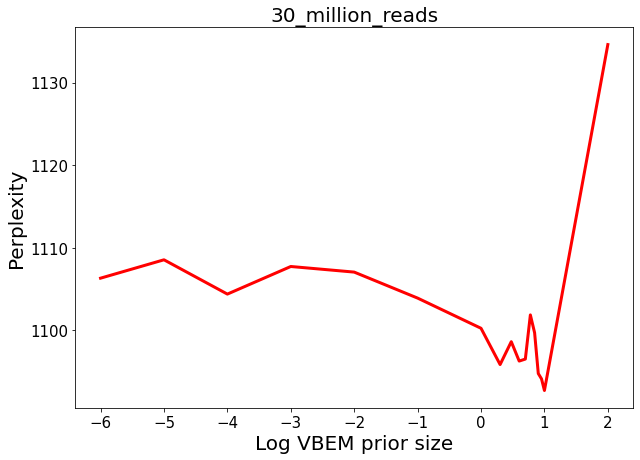

The smallest perplexity is 1092
The VBEM at the smallest perplexity is 10.0


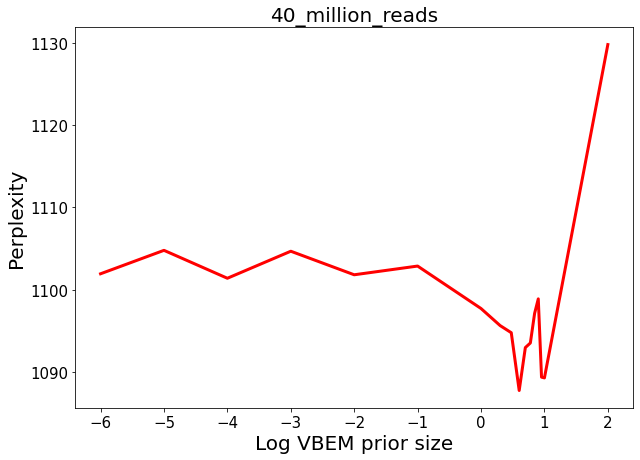

The smallest perplexity is 1087
The VBEM at the smallest perplexity is 4.0


In [5]:
def perplexity_plot_readdepth(sample, vb_priors):
    df = pd.DataFrame()
    for vb_prior in vb_priors:
        with open(perp_fp_fmt.format(sample=sample, vb_prior=vb_prior), 'r') as f:
            perp_result = yaml.safe_load(f)
        _vb_prior = float(vb_prior)
        df = df.append(dict(perplexity=perp_result['smoothed_perplexity'],
                            vb_prior=_vb_prior, log_vb_prior = np.log10(_vb_prior)), 
                       ignore_index=True)

    # find the minimum value in the df and convert to base 10 (not in logs)
    fig, ax = plt.subplots(1, 1, figsize=(10, 7))

    ax.set_title(sample, fontsize=20)
    sns.lineplot(x="log_vb_prior", y="perplexity", data=df, ax=ax, err_style=None, lw=3, color="red")

    ax.set_ylabel('Perplexity', fontsize=20)
    ax.set_xlabel('Log VBEM prior size', fontsize=20)
    ax.tick_params(axis='both', which='major', labelsize=15)

    plt.show()
    small = df.nsmallest(1, 'perplexity')
    print('The smallest perplexity is ' + str(int(small['perplexity'].values[0])))
    print('The VBEM at the smallest perplexity is ' + str(10**small['log_vb_prior'].values[0]))
    return ax

for sample in SAMPLES:
    perplexity_plot_readdepth(sample, VB_PRIORS)

Observe that the smallest perplexity decreases with increasing read depth. However the VBEM prior doesn't seem to be correlated with read depth. It could be possible that the optimal VBEM is independent of read depth, but we'd need some more experiments to support this.

## Conclusion

In this tutorial we demonstrated VBEM prior selection with RNA perplexity using k-fold cross validation and holdout validation. We also walked through some key highlights of our paper.

The most important takeaways are:

1. Perplexity is a proxy for RNA transcript abundance accuracy and can be used to select the best VBEM prior for a sample.

2. Different samples can have different perplexities and priors.

3. Increasing read depth lowers perplexity but not necessarily the prior.

Perplexity is not a one-size fits all approach, but can help produce more accurate RNA transcript abundance estimates, which will improve the results of downstream analysis and the biological insights that follow.

## Footnotes
<span id="fn1">1.</span> It should be noted that currently the kfold.sh script does not work for all input data. A Rust rewrite for correct functionality and improved performance is planned for the future.

<span id="fn2">2.</span> If you run Snakemake will all cores while other users who want to run jobs at the same time, they **will** get annoyed with you.

<span id="fn2">3.</span> Salmon collapses reads into equivalence classes during quantification to reduce time and memory. Perplexity also uses equivalence classes because computing the approximate likelihood over each equivalence class is faster than computing the real likelihood over each possible alignment for all fragments.